# Predicting the Sale Price of Bulldozers using Machine Learning

In this notebook, we're going to go through an example machine learning project with the goal of predicting the sale price of bulldozers.

## 1. Problem Definition

> How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for?

## 2. Data
The data is downloaded from the Kaggle Bluebook for Bulldozers competition:

There are 3 main datasets:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more detailed description of the competition visit:
https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

**Note**: The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model witch minimises RMSLE.

## 4. Features

Kaggle provides a data dictionary detailing all of the features of the dataset. You can view this on google sheets (or in the datafile)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [5]:
# Import training and validation sets
df = pd.read_csv('data/TrainAndValid.csv', low_memory=False)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [9]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

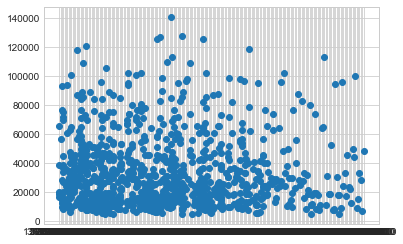

In [11]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000],df["SalePrice"][:1000])

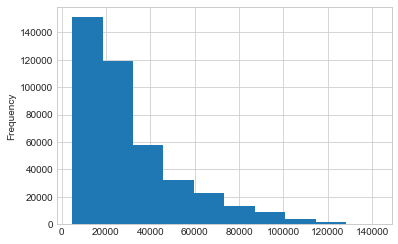

In [12]:
df.SalePrice.plot.hist()

### Parsing dates

When we work with time series data, we want to enrich the time & date component as much as possible.

We can do that by telling pandas which of our columns has dates in it using `parse_dates` parameter.

In [13]:
# Import data again but this time pasrse dates
df= pd.read_csv("data/TrainAndValid.csv",
                low_memory=False,
                parse_dates = ['saledate'])

In [15]:
df.saledate.dtype

dtype('<M8[ns]')

In [16]:
df.saledate.head(10)

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
5   2008-12-18
6   2004-08-26
7   2005-11-17
8   2009-08-27
9   2007-08-09
Name: saledate, dtype: datetime64[ns]

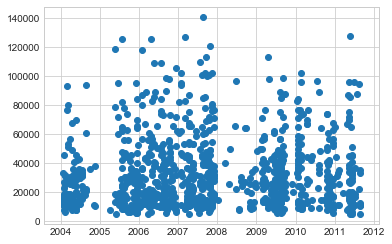

In [18]:
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000]);

In [20]:
df.head(10)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1139255,26500.0,1001274,4605,121,3.0,2004,508.0,Low,2008-12-18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1139256,21000.0,772701,1937,121,3.0,1993,11540.0,High,2004-08-26,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
7,1139261,27000.0,902002,3539,121,3.0,2001,4883.0,High,2005-11-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1139272,21500.0,1036251,36003,121,3.0,2008,302.0,Low,2009-08-27,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
9,1139275,65000.0,1016474,3883,121,3.0,1000,20700.0,Medium,2007-08-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional


In [25]:
# .head().T will show all the columns rather than trunkading them with ...
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000,57000,10000,38500,11000
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [27]:
df.saledate.head()

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
Name: saledate, dtype: datetime64[ns]

### Sort DataFrame by saledate

When working with time series data, its a good idea to sort it by date.

In [34]:
# Sort DataFrame in date order
df = df.sort_values(by=['saledate'])
df.saledate.tail()

409901   2012-04-28
405777   2012-04-28
411889   2012-04-28
411890   2012-04-28
409203   2012-04-28
Name: saledate, dtype: datetime64[ns]

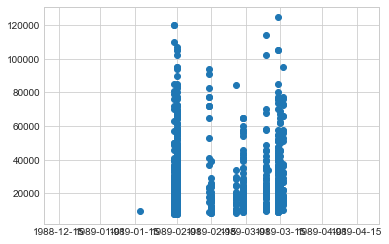

In [33]:
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000]);

### Make a copy of the original Dataframe

We make a copy of the original dataframe so when we maipulate the copy, we've still got our original data.

In [37]:
# Make a copy
df_temp = df.copy()

### Add datetime parameters for `saledate` column

In [41]:
df_temp['saleYear'] = df_temp.saledate.dt.year
df_temp['saleMonth'] = df_temp.saledate.dt.month
df_temp['saleDay'] = df_temp.saledate.dt.day
df_temp['dayofweek'] = df_temp.saledate.dt.dayofweek
df_temp['dayofyear'] = df_temp.saledate.dt.dayofyear

In [43]:
df_temp.head().T

,205615,233186,142491,115536,92301
SalesID,1646770,1728883,1508502,1452578,1403418
SalePrice,9500,30000,21000,33000,24000
MachineID,1126363,1523610,1153157,1544443,1390168
ModelID,8434,9105,4138,3854,7110
datasource,132,132,132,132,132
auctioneerID,18,99,99,99,99
YearMade,1974,1986,1972,1974,1986
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [44]:
# Now we've enrich our DataFrame with datetime features, we can remove 'saledate'
df_temp.drop('saledate', axis=1,inplace=True)

In [47]:
# Check the values of different columns
df_temp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Iowa               1336
Montana            1336
Oklahoma           1326
Nebraska            866
West Virginia   

In [50]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-nul

### Convert string to categories

One way we can turn all of our data into numbers is by converting them into pandas categories.

We can check the differe4nt datatypes compatible with pandas here
https://pandas.pydata.org/pandas-docs/stable/reference/general_utility_functions.html

In [52]:
pd.api.types.is_string_dtype(df_temp["UsageBand"])

True

In [70]:
# Find the columns with contain strings (my attempt)
is_string = []
for columns in df_temp:
    # print(columns)
    if pd.api.types.is_string_dtype(df_temp[f'{columns}']):
        is_string.append(columns)
is_string

['UsageBand',
 'fiModelDesc',
 'fiBaseModel',
 'fiSecondaryDesc',
 'fiModelSeries',
 'fiModelDescriptor',
 'ProductSize',
 'fiProductClassDesc',
 'state',
 'ProductGroup',
 'ProductGroupDesc',
 'Drive_System',
 'Enclosure',
 'Forks',
 'Pad_Type',
 'Ride_Control',
 'Stick',
 'Transmission',
 'Turbocharged',
 'Blade_Extension',
 'Blade_Width',
 'Enclosure_Type',
 'Engine_Horsepower',
 'Hydraulics',
 'Pushblock',
 'Ripper',
 'Scarifier',
 'Tip_Control',
 'Tire_Size',
 'Coupler',
 'Coupler_System',
 'Grouser_Tracks',
 'Hydraulics_Flow',
 'Track_Type',
 'Undercarriage_Pad_Width',
 'Stick_Length',
 'Thumb',
 'Pattern_Changer',
 'Grouser_Type',
 'Backhoe_Mounting',
 'Blade_Type',
 'Travel_Controls',
 'Differential_Type',
 'Steering_Controls']

In [68]:
# How me did it (easier)
for label, content in df_temp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [72]:
# this will turn all the string value into category values
for label, content in df_temp.items():
    if pd.api.types.is_string_dtype(content):
        df_temp[label] = content.astype('category').cat.as_ordered()

In [77]:
# we have changed the type of the object from a string object into a category object
# even though they look like strings when we play with them, pandas treats them as numbers
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [78]:
df_temp.state.cat.codes

205615    43
233186     8
142491     8
115536     8
92301      8
          ..
409901     4
405777     4
411889     4
411890     4
409203     4
Length: 412698, dtype: int8

Thanks to pandas Categories we now have a way to access all of our data in the form of numbers.

But we still have a bunch of missing data...

In [85]:
# Check missing data
df_temp.isna().sum()/len(df_temp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

### Save preprocessed manipulated data 

In [86]:
# Export current temp dataframe
df_temp.to_csv('data/train_temp.csv', index = False)

In [87]:
df_tmp = pd.read_csv('data/train_temp.csv', low_memory = False)

## Fill missing values

### Fill numerical missing values first

In [97]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)
        print(df_temp[label].isna().sum())

SalesID
0
SalePrice
0
MachineID
0
ModelID
0
datasource
0
auctioneerID
20136
YearMade
0
MachineHoursCurrentMeter
265194
saleYear
0
saleMonth
0
saleDay
0
dayofweek
0
dayofyear
0


In [98]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells us if the data was missing
            df_tmp[label + "_is_missing"] = pd.isnull(content)
            # fill missing numeric values with median
            df_tmp[label] = content.fillna(content.median())

In [103]:
# Check if there's any null numeric values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [106]:
df_tmp.auctioneerID_is_missing.value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

### Filling and turning categorical variables into numbers

In [110]:
# Check for columns which aren't numeric
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

UsageBand
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [113]:
# Turn categorical variabels into numbers and fill missing
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate whether sample had missing value
        df_tmp[label + "_is_missing"] = pd.isnull(content)
        # Turn categories into numbers and add +1
        # We add 1 because missing values are listed as -1 (which we dont want)
        df_tmp[label] = pd.Categorical(content).codes + 1

In [114]:
pd.Categorical(df_tmp['state']).codes

array([43,  8,  8, ...,  4,  4,  4], dtype=int8)

In [115]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 77.9 MB


In [116]:
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1728883,1508502,1452578,1403418
SalePrice,9500,30000,21000,33000,24000
MachineID,1126363,1523610,1153157,1544443,1390168
ModelID,8434,9105,4138,3854,7110
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,True
Blade_Type_is_missing,False,True,False,True,True
Travel_Controls_is_missing,False,True,False,True,True
Differential_Type_is_missing,True,True,True,False,True


In [119]:
# We now have no missing data as well as all numerical data
df_tmp.isna().sum().value_counts()

0    103
dtype: int64

Now that all of our data is numerica as well as our dataframe has no missing values, we should be able to build a machine learning model.

In [122]:
# Instantiate a ML model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_jobs= -1,random_state=42)

X = df_tmp.drop('SalePrice', axis =1)
y = df_tmp['SalePrice']

In [123]:
%%time
model.fit(X,y)

Wall time: 3min 39s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [125]:
# this score means very little as it was produced using the training data
model.score(X,y)

0.9875966080326709

### Splitting the data into train/validation sets

In [129]:
df_tmp.saleYear[df_tmp.saleYear>2011]

401125    2012
401126    2012
401127    2012
401128    2012
401129    2012
          ... 
412693    2012
412694    2012
412695    2012
412696    2012
412697    2012
Name: saleYear, Length: 11573, dtype: int64

In [143]:
# Split data into training and validation
df_val = df_tmp[df_tmp.saleYear==2012]
df_train = df_tmp[df_tmp.saleYear!=2012]

In [144]:
len(df_val),len(df_train)

(11573, 401125)

In [147]:
# Split data into X and y for train and validation sets
X_train = df_train.drop('SalePrice', axis=1)
y_train = df_train['SalePrice']

X_val = df_val.drop('SalePrice', axis=1)
y_val = df_val['SalePrice']

X_train.shape,y_train.shape,X_val.shape,y_val.shape

((401125, 102), (401125,), (11573, 102), (11573,))

### Building an evaluation function

In [157]:
# Create evaluation function (for RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test,y_preds):
    """
    Calculates root mean squared log error between predictions and true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test,y_preds))

# Create function to evaluate model on a few different levels

def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    scores = {"Training MAE": mean_absolute_error(y_train,train_preds),
             "Valid MAE": mean_absolute_error(y_val, val_preds),
             "Training RMSLE": rmsle(y_train,train_preds),
             "Valid RMSLE": rmsle(y_val,val_preds),
             "Training R^2": r2_score(y_train,train_preds),
             "Valid R^2": r2_score(y_val,val_preds)}
    return scores

## Testing our model on a subset (to tune the hyperparameters)

In [153]:
# # this takes far too long for experimenting because its 400k rows
# %%time
# model = RandomForestRegressor(n_jobs = -1, random_state=42)

# model.fit(X_train,y_train)

In [154]:
# Change max_samples value
model = RandomForestRegressor(n_jobs = -1,
                             random_state=42,
                             max_samples = 10000)

In [155]:
%%time
# cutting down on the max number of samples each estimator can see improves training time
model.fit(X_train,y_train)

Wall time: 10.5 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=10000, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [158]:
show_scores(model)

{'Training MAE': 5548.995840324089,
 'Valid MAE': 7179.6961392897265,
 'Training RMSLE': 0.25737726780537257,
 'Valid RMSLE': 0.29404344200903443,
 'Training R^2': 0.8610738743845616,
 'Valid R^2': 0.8320179198265638}

### Hyperparameter tuning with RandomizedSearchCV

In [161]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid = {"n_estimators": np.arange(10,100,10),
           "max_depth": [None,3,5,10],
           "min_samples_split": np.arange(2,20,2),
           "min_samples_leaf":np.arange(1,20,2),
           "max_features": [.5,1,'sqrt','auto'],
           "max_samples":[10000]}
# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                             param_distributions=rf_grid,
                             n_iter=10,
                             cv=5,
                             verbose=True)

# Fit the randomizedSearchCV model
rs_model.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  4.3min finished


Wall time: 4min 18s


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                   

In [163]:
# Find the best model hyperparameters
rs_model.best_params_

{'n_estimators': 20,
 'min_samples_split': 14,
 'min_samples_leaf': 11,
 'max_samples': 10000,
 'max_features': 'auto',
 'max_depth': None}

In [164]:
# Evaluate the RandomizedSearch model
show_scores(rs_model)

{'Training MAE': 6240.137571467409,
 'Valid MAE': 7843.3805187135895,
 'Training RMSLE': 0.28226742049155845,
 'Valid RMSLE': 0.3131818926777219,
 'Training R^2': 0.8235058276079847,
 'Valid R^2': 0.7907492143130792}

### Train a model with the best hyperparameters
**Note:** These were found after 100 iterations of `RandomizedSearchCV`.

In [165]:
%%time

# Most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                   min_samples_split=14,
                                   max_features=.5,
                                   n_jobs=-1,
                                   max_samples=None)

# Fit the ideal model
ideal_model.fit(X_train,y_train)

Wall time: 42.8 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=14, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [167]:
# original model scores (on all data)
show_scores(model)

{'Training MAE': 5548.995840324089,
 'Valid MAE': 7179.6961392897265,
 'Training RMSLE': 0.25737726780537257,
 'Valid RMSLE': 0.29404344200903443,
 'Training R^2': 0.8610738743845616,
 'Valid R^2': 0.8320179198265638}

In [168]:
# Scores on rs_model (trained on 10,000 examples)
show_scores(rs_model)

{'Training MAE': 6240.137571467409,
 'Valid MAE': 7843.380518713591,
 'Training RMSLE': 0.28226742049155845,
 'Valid RMSLE': 0.3131818926777219,
 'Training R^2': 0.8235058276079847,
 'Valid R^2': 0.7907492143130791}

In [166]:
# Improved model scores (trained on all data)
show_scores(ideal_model)

{'Training MAE': 2962.3223149801825,
 'Valid MAE': 5971.973170285854,
 'Training RMSLE': 0.1447919990107362,
 'Valid RMSLE': 0.24587342749757407,
 'Training R^2': 0.9585684177934236,
 'Valid R^2': 0.8817317876594036}

## Make predictions on test data

In [198]:
# Import the test data
df_test = pd.read_csv('data/Test.csv', low_memory=False,parse_dates=['saledate'])

### Preprocessing the data ( getting the test dataset in the same format as our training dataset)

In [199]:
def preprocess_data(df):
    '''
    Preforms tranformations on df and returns transformed df.
    '''
    df['saleYear'] = df.saledate.dt.year
    df['saleMonth'] = df.saledate.dt.month
    df['saleDay'] = df.saledate.dt.day
    df['dayofweek'] = df.saledate.dt.dayofweek
    df['dayofyear'] = df.saledate.dt.dayofyear
    df.drop('saledate', axis=1, inplace=True)
    
    # Fill the numeric rows with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column which tells us if the data was missing
                df[label + "_is_missing"] = pd.isnull(content)
                # fill missing numeric values with median
                df[label] = content.fillna(content.median())
    
    # Filled categorical values with numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label + '_is_missing'] = pd.isnull(content)
                # we add +1 to the category code becuase pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1
    
    
    
    return df

In [200]:
# Process the test data
df_test = preprocess_data(df_test)

In [201]:
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [202]:
# We can find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In [203]:
# Manually adjust df_test to have auctioneerID_is_missing column
df_test['auctioneerID_is_missing'] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


Finally now our test dataframe has the same features as our training dataframe, we can make predictions!

In [204]:
# Make predictions on the test data
test_preds = ideal_model.predict(df_test)
len(test_preds)

12457

We've made some predictions but they're not in the same format Kaggle is asking for

In [205]:
# Format predictions into the same format Kaggle is after
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds['SalesPrice'] = test_preds

In [206]:
df_preds

,SalesID,SalesPrice
0,1227829,19288.567718
1,1227844,20712.881816
2,1227847,43700.107431
3,1227848,53862.208187
4,1227863,41487.093704
...,...,...
12452,6643171,49418.040050
12453,6643173,15620.104585
12454,6643184,13233.153667
12455,6643186,21084.698079


In [207]:
# Export prediction data
df_preds.to_csv('data/test_predictions.csv', index=False)

### Feature Importance

Feature importance seeks to figure our which different attributes of the data were most important when it comes to predicting the **target variable** (SalePrice).

In [209]:
# Find feature importance of our best model
len(ideal_model.feature_importances_)

102

In [222]:
# Helper function for plotting feature importance
def plot_features(columns,importances,n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances}).sort_values('feature_importances',ascending=False).reset_index(drop=True))
        
    #plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df['features'][:n],df['feature_importances'][:20])
    ax.set_ylabel('Features')
    ax.set_xlabel('Feature Importances')
    ax.invert_yaxis()

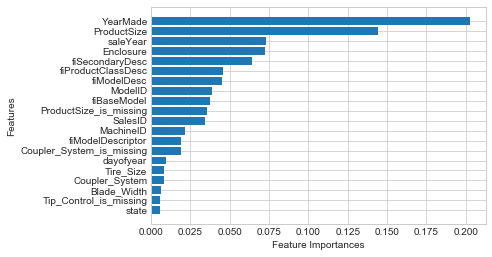

In [223]:
plot_features(X_train.columns,ideal_model.feature_importances_)

** Question to finish:** Why might knowing the feature importances of a trained machine learning machine learning model be helpful?